# 변동성 모멘텀 혼합 전략

- 포트폴리오 유니버스
    - 포트폴리오 구성 : 주식 / 채권 / 현금군으로 구성
    - 주식 : 한국 주식(코스피200), 미국 주식(S&P500)
    - 채권 : 한국 10년 국채, 미국 10년 국채
    - 현금 : 한국 3년 만기 국고채
    - kodex200, us500_UH, kbond10y, usbond10y_UH, kbond3y
    - 기간 : 2003.6 ~ 2017.6
- 방법 : 절대 모멘텀 + 변동성 전략
    - 포트폴리오 개별 구성 종목의 1~12개월 **평균 모멘텀 계산**
    - **현금 비중** = (평균 모멘텀 값 < 1 자산 개수) / (전체 포트폴리오 자산 개수)
    - **포트폴리오 투자 비중** = 1 - 현금 비중
    - 개별 구성 종목의 변동성 = 1개월 수익률의 **최근 12개월 표준 편차**
    - 개별 종목 투자 비중 = (평균 모멘텀 / 변동성) x 포트폴리오 투자 비중(평균 모멘텀 < 1인 종목은 투자 안함)
    - 매월 리밸런싱
- 예제
    - A, B, C 3가지 자산으로 구성된 포트폴리오가 있다. 이번 달의 투자비중을 구하시오
        - 평균 모멘텀 : 1.5(A), 0.8(B), 1.2(C)
        - 변동성 : 8%(A), 10%(B), 2%(C)
        - 현금비중 = 1/3 = 33%
            - 모멘텀이 1보다 작은 하락 추세에 있는 자산 개수/ 전체 자산 개수
        - 투자비중 = 67%
        - 평균 모멘텀/변동성 계산
            - A : 1.5/8=0.1875
            - B : 평균 모멘텀 < 1 -> 투자 안함
            - C : 1.2/2 = 0.6
        - 각 자산별 투자 비중
            - A : 0.1875/(0.1875+0.6) = 24%
            - C : 0.6/(0.1875+0.6) = 76%
        - 최종 투자 비중
            - 현금 : 33%
            - 투자 비중(67%)
                - A : 67 x 0.24 = 16%
                - B : 0%
                - C : 67 x 0.76 = 51%

In [1]:
from settings import *

## 데이타 읽기

In [2]:
df = get_data()

In [3]:
tickers = ['kodex200', 'kbond3y', 'kbond10y', 'us500_UH', 'usbond10y_UH']

In [4]:
df = df[tickers].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5433 entries, 2000-01-04 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kodex200      5433 non-null   float64
 1   kbond3y       5433 non-null   float64
 2   kbond10y      5433 non-null   float64
 3   us500_UH      5433 non-null   float64
 4   usbond10y_UH  5433 non-null   float64
dtypes: float64(5)
memory usage: 254.7 KB


In [6]:
# 기간 : 2003.6 ~ 2017.6
s = '2002-6-27'
e = '2017-6-30'
start = '2003-6-28'

In [7]:
data = df[s:e].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3721 entries, 2002-06-27 to 2017-06-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kodex200      3721 non-null   float64
 1   kbond3y       3721 non-null   float64
 2   kbond10y      3721 non-null   float64
 3   us500_UH      3721 non-null   float64
 4   usbond10y_UH  3721 non-null   float64
dtypes: float64(5)
memory usage: 174.4 KB


## 전략 클래스 작성 WeighMomentumVolRatio

In [8]:
class WeighMomentumVolRatio(bt.Algo):
    """ 모멘텀 변동성 비중조절

    - 포트폴리오 개별 구성 종목의 1~12개월 평균 모멘텀 계산
    - 현금 비중 = (평균 모멘텀 값 < 1 자산 개수) / (전체 포트폴리오 자산 개수)
    - 포트폴리오 투자 비중 = 1- 현금비중
    - 개별 구성 종목의 변동성 = 1개월 수익률의 최근 12개월 표준편차
    - 개별 종목 투자 비중 = 평균 모멘텀 / 변동성 포트폴리오 투자 비중(평균 모멘텀 < 1 인 종목은 투자 안 함)
    - 매월 반복하며 리밸런싱
    """
    def __init__(self, months=12, lag=pd.DateOffset(days=0), cash_name='현금'):
        super(WeighMomentumVolRatio, self).__init__()
        self.lookback = months
        self.lag = lag
        self.cash_name = cash_name

    def avearge_momentum(self, t0, prices):
        momentums = 0
        for m in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=m)
            prc = prices.loc[start:t0]
            momentum = prc.iloc[-1] / prc.iloc[0]
            momentums += momentum

        return momentums/self.lookback

    def average_momentum_score(self, t0, prices):
        momentums_score = 0
        for m in range(1, self.lookback+1):
            start = t0 - pd.DateOffset(months=m)
            prc = prices.loc[start:t0]
            momentum_score = np.where(prc.calc_total_return() > 0, 1, 0)
            momentums_score += momentum_score

        return momentums_score / self.lookback


    def __call__(self, target):
        """
        - 포트폴리오 개별 구성 종목의 1~12개월 평균 모멘텀 계산
        - 현금 비중 = (평균 모멘텀 값 < 1 자산 개수) / (전체 포트폴리오 자산 개수)
        - 포트폴리오 투자 비중 = 1- 현금비중
        - 개별 구성 종목의 변동성 = 1개월 수익률의 최근 12개월 표준편차
        - 개별 종목 투자 비중 = 평균 모멘텀 / 변동성 포트폴리오 투자 비중(평균 모멘텀 < 1 인 종목은 투자 안 함)
        - 매월 반복하며 리밸런싱
        """
        selected = target.temp['selected'].copy()

        selected.remove(self.cash_name)

        t0 = target.now - self.lag
        start = t0 - pd.DateOffset(months=self.lookback)
        prc = target.universe.loc[start:t0, selected]

        if target.universe[selected].index[0] > start:
            return False

        평균모멘텀 = self.avearge_momentum(t0, prc)
        현금비중 = (평균모멘텀 < 1).sum()/len(평균모멘텀)
        포트폴리오투자비중 = 1 - 현금비중
        월별수익률 = prc.resample('M').last().pct_change().dropna()
        변동성 = 월별수익률.std()
        평균모멘텀_변동성 = 평균모멘텀.div(변동성)
        투자비중 = 평균모멘텀_변동성.div(평균모멘텀_변동성.sum())
        개별종목투자비중 = 투자비중*포트폴리오투자비중
        현금투자비중 = 1 - 개별종목투자비중.sum()
        # print(f"prc {t0} ~ {start}")
        # print(f"평균모멘텀 {평균모멘텀}")
        # print(f"현금비중 {현금비중}")
        # print(f"포트폴리오투자비중 {포트폴리오투자비중}")
        # print(f"변동성 {변동성}")
        # print(f"평균모멘텀.div(변동성) {평균모멘텀_변동성}")
        # print(f"투자비중 {투자비중}")
        # print(f"개별종목투자비중 {개별종목투자비중.sum()}\n{개별종목투자비중} ")
        # print(f"현금투자비중 {현금투자비중}")

        weights = 개별종목투자비중
        if weights.sum() > 1: #XXX 2010-9-30에 비중이 1을 조금 넘어 현금에 "-"비중이 들어간다.
            weights[self.cash_name] = 0.0
        else:
            weights[self.cash_name] = 1 - weights.sum()

        target.temp['weights'] = weights

        return True

In [9]:
def strategy_momentum_vol(name, start, data, months=12, lag=pd.DateOffset(days=0), cash_name='현금'):
    s = bt.Strategy(name,
            [
                bt.algos.RunMonthly(run_on_end_of_period=True),
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighMomentumVolRatio(months, lag, cash_name),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

## 백테스팅 실행

현금은 kbond3y

In [10]:
bt_모멘텀변동성 = strategy_momentum_vol("모멘텀변동성", start, data,
                                     12, pd.DateOffset(days=0), 'kbond3y')

In [11]:
r_모멘텀변동성 = bt.run(bt_모멘텀변동성)

2003-06-30 00:00:00 모멘텀변동성 kodex200:0.088 kbond10y:0.574 us500_UH:0.132 usbond10y_UH:0.206 kbond3y:0.000 
2003-07-31 00:00:00 모멘텀변동성 kodex200:0.096 kbond10y:0.339 us500_UH:0.140 usbond10y_UH:0.175 kbond3y:0.250 
2003-08-29 00:00:00 모멘텀변동성 kodex200:0.099 kbond10y:0.334 us500_UH:0.139 usbond10y_UH:0.178 kbond3y:0.250 
2003-09-30 00:00:00 모멘텀변동성 kodex200:0.093 kbond10y:0.317 us500_UH:0.147 usbond10y_UH:0.193 kbond3y:0.250 
2003-10-31 00:00:00 모멘텀변동성 kodex200:0.133 kbond10y:0.372 us500_UH:0.220 usbond10y_UH:0.275 kbond3y:0.000 
2003-11-28 00:00:00 모멘텀변동성 kodex200:0.140 kbond10y:0.348 us500_UH:0.223 usbond10y_UH:0.290 kbond3y:0.000 
2003-12-30 00:00:00 모멘텀변동성 kodex200:0.152 kbond10y:0.325 us500_UH:0.245 usbond10y_UH:0.278 kbond3y:0.000 
2004-01-30 00:00:00 모멘텀변동성 kodex200:0.114 kbond10y:0.235 us500_UH:0.207 usbond10y_UH:0.193 kbond3y:0.250 
2004-02-27 00:00:00 모멘텀변동성 kodex200:0.117 kbond10y:0.230 us500_UH:0.199 usbond10y_UH:0.205 kbond3y:0.250 
2004-03-31 00:00:00 모멘텀변동성 kodex200:0.167 kbon

## 성과 분석

In [16]:
start

'2003-6-28'

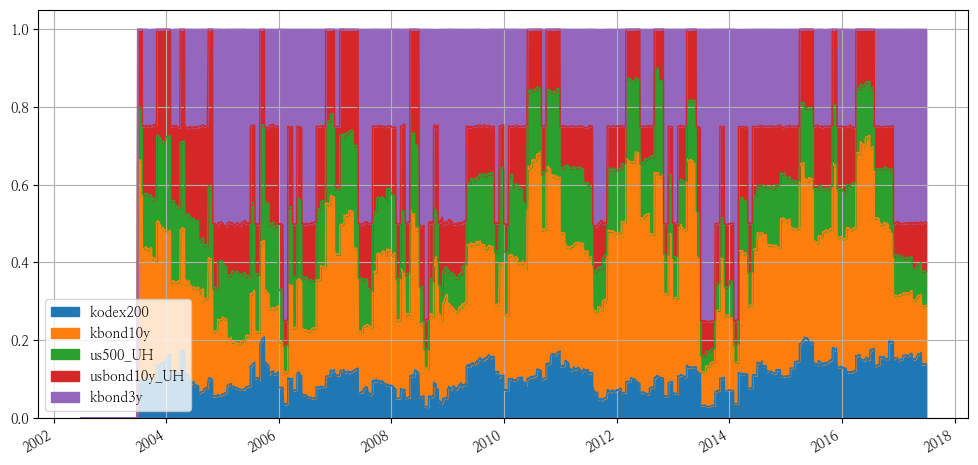

In [13]:
r_모멘텀변동성.set_date_range(start)
r_모멘텀변동성.get_security_weights().plot.area(figsize=(12,6));

In [17]:
r_모멘텀변동성.display()

Stat                 모멘텀변동성
-------------------  --------------
Start                2003-06-30
End                  2017-06-30
Risk-free rate       0.00%

Total Return         124.52%
Daily Sharpe         1.41
Daily Sortino        2.28
CAGR                 5.95%
Max Drawdown         -6.41%
Calmar Ratio         0.93

MTD                  0.81%
3m                   2.75%
6m                   3.49%
YTD                  3.49%
1Y                   4.59%
3Y (ann.)            6.75%
5Y (ann.)            5.40%
10Y (ann.)           6.63%
Since Incep. (ann.)  5.95%

Daily Sharpe         1.41
Daily Sortino        2.28
Daily Mean (ann.)    5.96%
Daily Vol (ann.)     4.22%
Daily Skew           -0.37
Daily Kurt           14.80
Best Day             3.02%
Worst Day            -2.69%

Monthly Sharpe       1.72
Monthly Sortino      3.51
Monthly Mean (ann.)  5.85%
Monthly Vol (ann.)   3.40%
Monthly Skew         -0.56
Monthly Kurt         0.87
Best Month           3.23%
Worst Month          -3.04%

Yearly

In [18]:
r_모멘텀변동성.prices.resample('M').last().to_drawdown_series().min()

모멘텀변동성   -0.036
dtype: float64

In [19]:
assets =  ['kodex200', 'kbond10y', 'us500_UH', 'usbond10y_UH']
bt_ew = long_only_ew(data, assets, "동일비중")
bt_코스피200 = long_only_ew(data, ["kodex200"], "코스피200")
bt_us500 = long_only_ew(data, ["us500_UH"], "S&P500")
bt_kbond10y = long_only_ew(data, ["kbond10y"], "한국10년국채")
bt_usbond10y = long_only_ew(data, ["usbond10y_UH"], "미국10년국채")

In [20]:
r_ew = bt.run(bt_ew)
r_코스피200 = bt.run(bt_코스피200)
r_us500 = bt.run(bt_us500)
r_kbond10y = bt.run(bt_kbond10y)
r_usbond10y = bt.run(bt_usbond10y)
r_all = bt.run(bt_모멘텀변동성, bt_ew, bt_코스피200, bt_us500, bt_kbond10y, bt_usbond10y)

2002-06-27 00:00:00
2002-06-27 00:00:00
2002-06-27 00:00:00
2002-06-27 00:00:00
2002-06-27 00:00:00


In [21]:
r_all.set_date_range(start)
r_ew.set_date_range(start)
r_코스피200.set_date_range(start)
r_us500.set_date_range(start)
r_kbond10y.set_date_range(start)
r_usbond10y.set_date_range(start)

In [22]:
r_all.stats

,모멘텀변동성,동일비중,코스피200,S&P500,한국10년국채,미국10년국채
start,2003-06-30 00:00:00,2003-06-30 00:00:00,2003-06-30 00:00:00,2003-06-30 00:00:00,2003-06-30 00:00:00,2003-06-30 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000,0.000,0.000,0.000,0.000
total_return,1.245,1.742,3.614,2.143,0.940,0.610
cagr,0.059,0.075,0.115,0.085,0.048,0.035
max_drawdown,-0.064,-0.185,-0.527,-0.280,-0.120,-0.293
calmar,0.928,0.405,0.219,0.305,0.405,0.118
mtd,0.008,0.020,0.024,0.030,0.001,0.016
three_month,0.027,0.062,0.114,0.053,0.002,0.036
six_month,0.035,0.076,0.210,0.033,-0.002,-0.026


In [24]:
r_all.prices.resample('M').last().to_drawdown_series().describe()

,모멘텀변동성,동일비중,코스피200,S&P500,한국10년국채,미국10년국채
count,169.000,169.000,169.000,169.000,169.000,169.000
mean,-0.005,-0.015,-0.091,-0.038,-0.022,-0.107
std,0.008,0.026,0.092,0.046,0.025,0.066
min,-0.036,-0.139,-0.455,-0.223,-0.108,-0.257
25%,-0.007,-0.021,-0.127,-0.051,-0.040,-0.156
50%,0.000,-0.001,-0.078,-0.024,-0.016,-0.103
75%,0.000,0.000,-0.021,0.000,0.000,-0.058
max,0.000,0.000,0.000,0.000,0.000,0.000


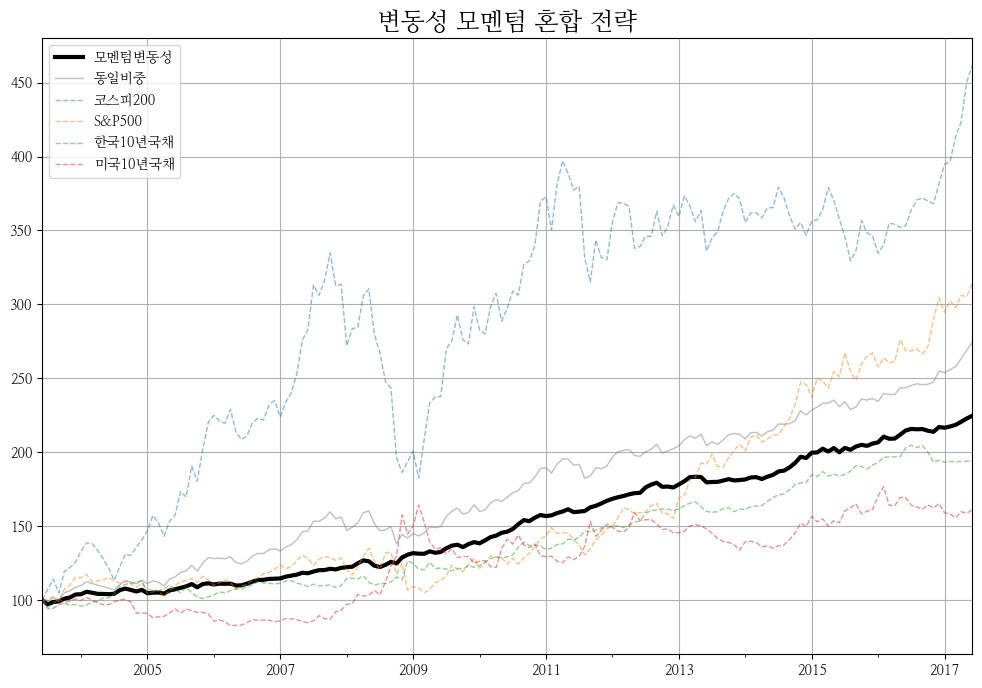

In [25]:
ax1 = r_모멘텀변동성.plot(freq='M', lw=3, color='black', figsize=(12,8));
r_ew.plot(ax=ax1, freq='M', lw=1, color="gray", alpha=0.5, figsize=(12, 8));
r_코스피200.plot(ax=ax1, freq='M', ls='--',  alpha=0.5, figsize=(12, 8));
r_us500.plot(ax=ax1, freq='M', ls='--', alpha=0.5, figsize=(12, 8));
r_kbond10y.plot(ax=ax1, freq='M', ls='--', alpha=0.5, figsize=(12, 8));
r_usbond10y.plot(ax=ax1, freq='M', ls='--', alpha=0.5, figsize=(12, 8));
plt.title("변동성 모멘텀 혼합 전략", size=18);

## 책과 데이터가 다르다.

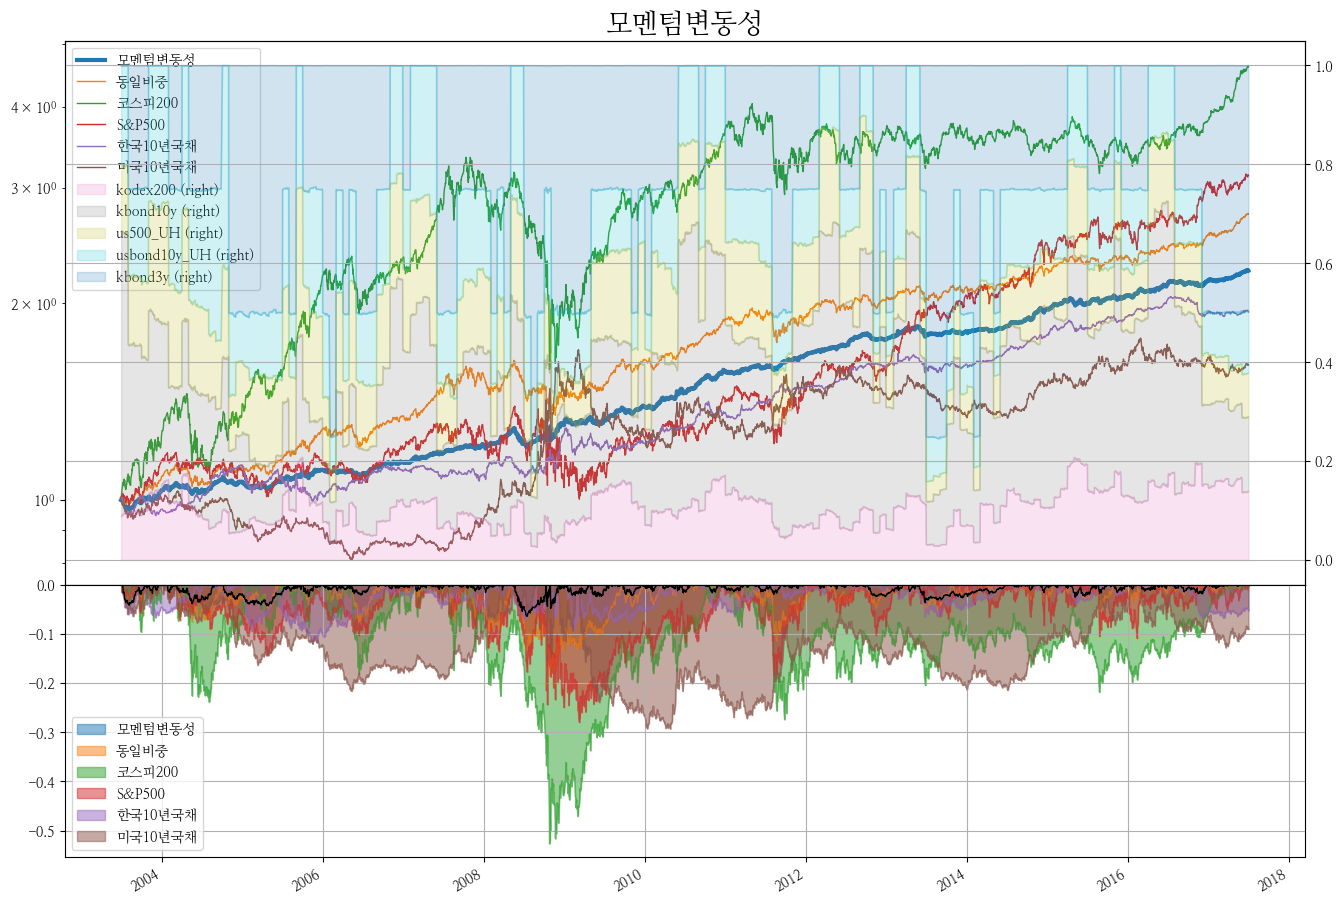

In [26]:
plot_assets(r_all, start, e, "모멘텀변동성")

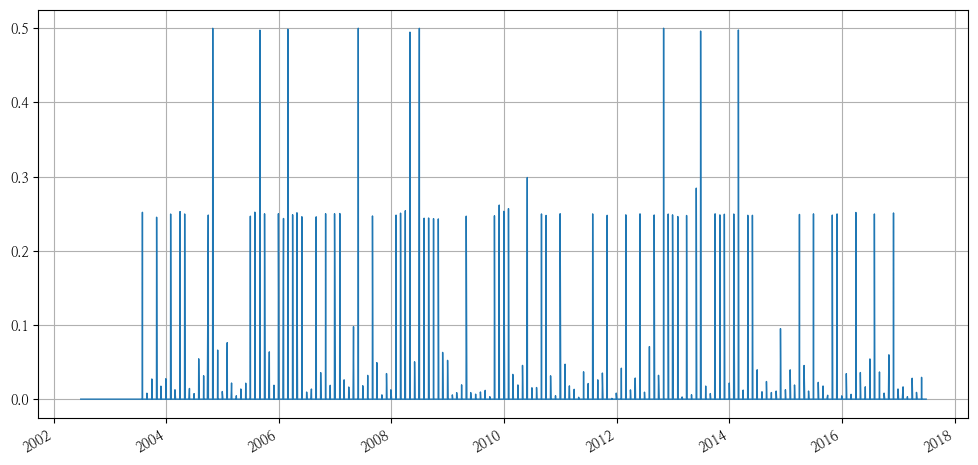

In [31]:
bt_모멘텀변동성.turnover.plot(figsize=(12,6));

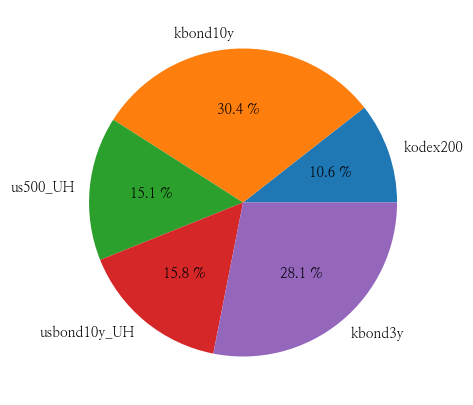

In [35]:
r_모멘텀변동성.get_security_weights().sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

In [37]:
r_all.backtests['모멘텀변동성'].stats.drawdown_details.sort_values(by="Length", ascending=False).head(20)

,Start,End,Length,drawdown
185,2013-05-20 00:00:00,2014-07-02 00:00:00,408,-0.036
21,2004-10-07 00:00:00,2005-08-31 00:00:00,328,-0.043
27,2006-01-16 00:00:00,2006-08-03 00:00:00,199,-0.021
13,2004-03-08 00:00:00,2004-08-26 00:00:00,171,-0.039
78,2008-05-16 00:00:00,2008-10-28 00:00:00,165,-0.064
228,2016-07-27 00:00:00,2016-12-28 00:00:00,154,-0.018
179,2012-10-05 00:00:00,2013-02-21 00:00:00,139,-0.024
211,2015-04-14 00:00:00,2015-08-18 00:00:00,126,-0.025
1,2003-07-08 00:00:00,2003-10-28 00:00:00,112,-0.042
134,2011-06-01 00:00:00,2011-09-14 00:00:00,105,-0.020


In [ ]:
r_all.backtests['AllRound_Net'].stats.drawdown_details.sort_values('drawdown')